In [20]:
from structuralcodes.codes.ec2_2004 import __materials__
from structuralcodes.materials.concrete import ConcreteEC2_2004,ConcreteEC2_2023
from structuralcodes.materials.reinforcement import ReinforcementEC2_2023,ReinforcementEC2_2004
from shapely import Polygon
from structuralcodes import codes, materials
from structuralcodes.geometry import SurfaceGeometry,CompoundGeometry,Geometry
from structuralcodes.sections._reinforcement import (
    add_reinforcement,
    add_reinforcement_line,
)
from structuralcodes.sections._generic import GenericSection
from structuralcodes.materials.constitutive_laws import Elastic, ElasticPlastic,ParabolaRectangle
from structuralcodes.plots.section_plots import draw_section,draw_constitutive_law,draw_My_Mz_diagram,draw_section_response,draw_N_M_diagram
import math
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint


1) reinforced_concrete atribute of CompoundGeometry class change when rotating or translating 

In [24]:
codes.set_design_code(design_code='ec2_2004')
concrete = materials.concrete.create_concrete(fck=25)
reinforcemnet = materials.reinforcement.create_reinforcement(
    fyk=500,
    Es=200000,
    density=7850,
    ftk=500,
    epsuk=0.07,
)
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(
    geo, (50, 450), (300, 450), 12, reinforcemnet, n=3
)
geo = add_reinforcement_line(geo, (50, 50), (300, 50), 20, reinforcemnet, n=6)
sec = GenericSection(
    geo,
)
# sec.geometry = sec.geometry.translate(-sec.gross_properties.cy, -sec.gross_properties.cz)
print('Is reinforced concrete: ',sec.geometry.reinforced_concrete)
sec.geometry = sec.geometry.rotate(0.2)
#sec.geometry = sec.geometry.translate(-175, -250)
print('Is reinforced concrete: ',sec.geometry.reinforced_concrete)

Is reinforced concrete:  True
Is reinforced concrete:  False


2) Sign criteria of calculate_bending_strength results semms strange. Moments results follow global cordiante system but chi results folow rotated corditante system (theta). Is this a bug?

====== SECTION ======
====== Theta = 0 ======
UltimateBendingMomentResults(theta=0,
                             n=-0.0029919976950623095,
                             m_y=-562853427.1074414,
                             m_z=4.4796883128622224e-08,
                             chi_y=-3.909551620178221e-05,
                             chi_z=0,
                             eps_a=0.00627387905044555)
====== Theta = pi ======
UltimateBendingMomentResults(theta=3.141592653589793,
                             n=-0.0029919963562861085,
                             m_y=562853427.107441,
                             m_z=-1.286277091120944e-07,
                             chi_y=-3.909551620178221e-05,
                             chi_z=0,
                             eps_a=0.00627387905044555)


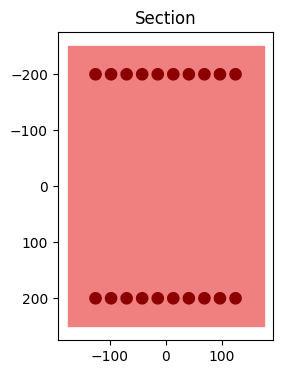

In [27]:
# Materials
concrete = ConcreteEC2_2004(25)
reinforcement = ReinforcementEC2_2023(fyk=500, Es=200000, density=7850, ftk=550, epsuk=0.07)

# Create section
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 20, reinforcement, n=10)
geo = add_reinforcement_line(geo, (50, 50), (300, 50), 20, reinforcement, n=10)
geo = geo.translate(-175,-250)
sec = GenericSection(geo)

# Draw & print
print("====== SECTION ======")
print("====== Theta = 0 ======")
pprint(sec.section_calculator.calculate_bending_strength(theta=0))
print("====== Theta = pi ======")
pprint(sec.section_calculator.calculate_bending_strength(theta=math.pi))
draw_section(sec)

12. When calculating the geometric properties EA, EI uses the tangent modulus at eps=0. With concrete it does not use Ecm. 
In order to homogenise a section it is now necessary to adapt Es =Ec,tang.
Would be usefull to get section properties in homogenised section using Ecm. Instead of using E=constitutive_law.get_tangent(0)[0], a parameter of E could be entered for each material just for gross properties calculation. The default should be Ecm for concrete and constitutive_law.get_tangent(0)[0] for others.




Should be SurfaceGeometry class inherited from Geometry class??